#**Download csv**

In [ ]:
%%capture
import pandas as pd
!wget -O 'train.csv' 'https://raw.githubusercontent.com/aaron6347/CPT346-Asn2/main/sentiment/train.csv'
!wget -O 'test.csv' 'https://raw.githubusercontent.com/aaron6347/CPT346-Asn2/main/sentiment/test.csv'
!wget -O 'validation.csv' 'https://raw.githubusercontent.com/aaron6347/CPT346-Asn2/main/sentiment/validation.csv'
train_data = pd.read_csv('train.csv', header=None, names=['sentence','sentiment'])
test_data = pd.read_csv('test.csv', header=None, names=['sentence','sentiment'])
validation_data = pd.read_csv('validation.csv', header=None, names=['sentence','sentiment'])
train_sentence = train_data['sentence']
train_sentiment = train_data['sentiment']
test_sentence = test_data['sentence']
test_sentiment = test_data['sentiment']
validation_sentence = validation_data['sentence']
validation_sentiment = validation_data['sentiment']

#**Data Preprocessing Function**

In [2]:
%%capture
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

def preprocessing(sentence_data):
  set_stopwords = set(stopwords.words('english'))
  lemmatizer = WordNetLemmatizer()
  for sentence in sentence_data:
    #remove punctuations from sentences
    no_punctuation_sentence = sentence.translate(str.maketrans('', '', string.punctuation))
    #split sentences into tokens
    tokens = word_tokenize(no_punctuation_sentence)
    #lowercase tokens, remove stopwords and lemmatize tokens
    preprocessed_tokens = [lemmatizer.lemmatize(token.lower()) for token in tokens if token.lower() not in set_stopwords]
    #join back all preproccessed tokens into sentence format
    preprocessed_sentence = " ".join(preprocessed_tokens)
    #replace sentence
    sentence_data = sentence_data.replace(to_replace = sentence, value = preprocessed_sentence)
  return sentence_data

#**Run Data Preprocessing**

In [3]:
%%capture
processed_train_sentence = preprocessing(train_sentence)
processed_test_sentence = preprocessing(test_sentence)
processed_validation_sentence = preprocessing(validation_sentence)

#**Import glove.6B**

In [4]:
%%capture
# check if glove.6B.100.txt exist, else download
import os.path  
if not os.path.isfile("glove.6B.100d.txt"):
  !wget -O 'glove.6B.zip' http://nlp.stanford.edu/data/glove.6B.zip
  !unzip -j "glove.6B.zip" "glove.6B.100d.txt"

#**Create glove.6B.100D model**

In [5]:
from gensim.scripts.glove2word2vec import glove2word2vec
glove2word2vec("glove.6B.100d.txt", "glove.6B.100d.word2vec")

from gensim.models import KeyedVectors
glove_model = KeyedVectors.load_word2vec_format("glove.6B.100d.word2vec", binary=False)

#**Glove vector Function**

In [21]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical

def vector_representation(model, data, label):
    #to determine the dimensionality of vector
    D = model.get_vector('king').shape[0]

    X = []
    max = 0
    emptycount = 0
    for sentence in data:
      tokens = word_tokenize(sentence)
      vecs = []
      m = 0

      for word in tokens:
        try:
          vec = model.get_vector(word)
          vecs.append(vec)
          m += 1
        except KeyError:
          vecs.append(np.zeros(D))
      if len(vecs) > 0:
        vecs = np.array(vecs)
        X.append(vecs)
        if len(vecs) > max:
          max = len(vecs)
      if np.sum(vecs)==0:
        emptycount += 1
    print("Number of samples with no words found: %s / %s" % (emptycount, len(data)))
    padded_X = keras.preprocessing.sequence.pad_sequences(X, maxlen=64, dtype='float32')
    encoded_sentiment = to_categorical(label, num_classes=3)

    return padded_X, encoded_sentiment

#**Run Glove word embedding vector**

In [7]:
train_vector, train_sentiment_vector = vector_representation(glove_model, processed_train_sentence, train_sentiment)
test_vector, test_sentiment_vector = vector_representation(glove_model, processed_test_sentence, test_sentiment)
validation_vector, validation_sentiment_vector = vector_representation(glove_model, processed_validation_sentence, validation_sentiment)

Number of samples with no words found: 138 / 61692
Number of samples with no words found: 1 / 1000
Number of samples with no words found: 4 / 1000


#**Create Neural Network**

In [8]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Input(shape=(64,100), dtype='float32'))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100, activation='relu')))
model.add(tf.keras.layers.Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# tf.keras.utils.plot_model(model, show_shapes=True)

#**Run Neural Network**

In [9]:
result = model.fit(train_vector, train_sentiment_vector, epochs=10, batch_size=64, validation_data=(validation_vector, validation_sentiment_vector))

Epoch 1/10
964/964 [==============================] - 293s 299ms/step - loss: 1.5504 - accuracy: 0.5429 - val_loss: 0.9003 - val_accuracy: 0.5500
Epoch 2/10
964/964 [==============================] - 289s 300ms/step - loss: 0.8556 - accuracy: 0.5962 - val_loss: 0.8926 - val_accuracy: 0.5430
Epoch 3/10
964/964 [==============================] - 290s 301ms/step - loss: 0.8076 - accuracy: 0.6286 - val_loss: 0.8868 - val_accuracy: 0.5500
Epoch 4/10
964/964 [==============================] - 289s 299ms/step - loss: 0.7693 - accuracy: 0.6567 - val_loss: 0.8677 - val_accuracy: 0.5730
Epoch 5/10
964/964 [==============================] - 287s 297ms/step - loss: 0.7412 - accuracy: 0.6751 - val_loss: 0.9108 - val_accuracy: 0.5430
Epoch 6/10
964/964 [==============================] - 287s 298ms/step - loss: 0.7187 - accuracy: 0.6880 - val_loss: 0.8745 - val_accuracy: 0.5670
Epoch 7/10
964/964 [==============================] - 288s 298ms/step - loss: 0.7003 - accuracy: 0.7000 - val_loss: 0.8910 -

#**Model's Evaluation**

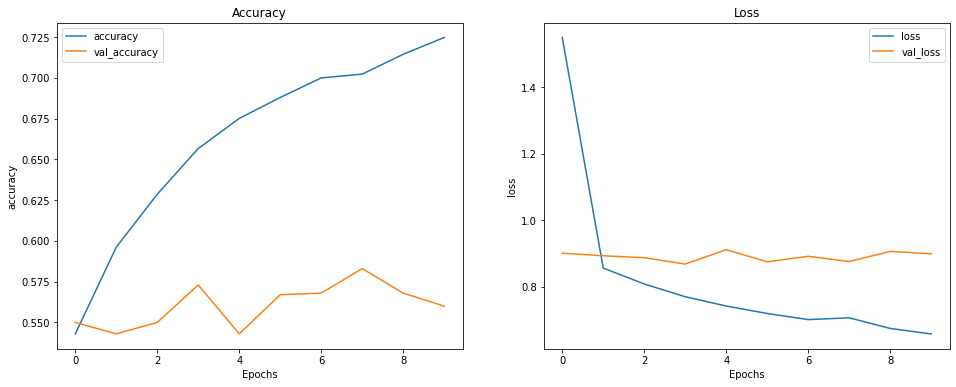

In [10]:
import matplotlib.pyplot as plt
def plot_graphs(result, metric, title):
  plt.plot(result.history[metric])
  plt.plot(result.history['val_'+metric], '')
  plt.title(title)
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(result, 'accuracy', 'Accuracy')
plt.subplot(1, 2, 2)
plot_graphs(result, 'loss', 'Loss')

In [11]:
loss, acc = model.evaluate(test_vector, test_sentiment_vector)
print("Loss: {}, Accuracy: {}".format(loss, acc))

32/32 [==============================] - 1s 33ms/step - loss: 0.8383 - accuracy: 0.6230
Loss: 0.838312566280365, Accuracy: 0.6230000257492065


Text(33.0, 0.5, 'Actual')

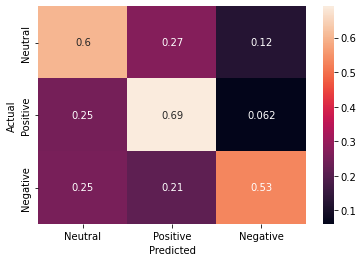

In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

labels=['Neutral','Positive','Negative']
pred = model.predict(test_vector)
pred_cat = tf.argmax(pred, axis=-1)
actual_cat = tf.argmax(test_sentiment_vector, axis=-1)
confusion_mat = tf.math.confusion_matrix(actual_cat, pred_cat)
confusion_mat = confusion_mat/confusion_mat.numpy().sum(axis=1)[:, tf.newaxis]
sns.heatmap(confusion_mat, annot=True, xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")

#**Improved Model**


In [19]:
model2 = tf.keras.Sequential()
model2.add(tf.keras.layers.Input(shape=(64,100), dtype='float32'))
model2.add(tf.keras.layers.Masking())
model2.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100, activation='relu', recurrent_dropout=0.5)))
model2.add(tf.keras.layers.Dense(50, activation='relu'))
model2.add(tf.keras.layers.Dense(3, activation='softmax'))
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
tf.keras.utils.plot_model(model2, show_shapes=True)

In [20]:
result2 = model2.fit(train_vector, train_sentiment_vector, epochs=10, batch_size=64, validation_data=(validation_vector, validation_sentiment_vector))

Epoch 1/10
964/964 [==============================] - 699s 720ms/step - loss: 0.8286 - accuracy: 0.6169 - val_loss: 0.8900 - val_accuracy: 0.5600
Epoch 2/10
964/964 [==============================] - 666s 691ms/step - loss: 0.7295 - accuracy: 0.6826 - val_loss: 0.9348 - val_accuracy: 0.5550
Epoch 3/10
964/964 [==============================] - 662s 687ms/step - loss: 0.6850 - accuracy: 0.7069 - val_loss: 0.9226 - val_accuracy: 0.5670
Epoch 4/10
964/964 [==============================] - 671s 696ms/step - loss: 0.6478 - accuracy: 0.7276 - val_loss: 0.9640 - val_accuracy: 0.5560
Epoch 5/10
964/964 [==============================] - 683s 708ms/step - loss: 0.6160 - accuracy: 0.7433 - val_loss: 0.9189 - val_accuracy: 0.5850
Epoch 6/10
964/964 [==============================] - 727s 755ms/step - loss: 0.5856 - accuracy: 0.7568 - val_loss: 0.9803 - val_accuracy: 0.5870
Epoch 7/10
964/964 [==============================] - 681s 706ms/step - loss: 0.5551 - accuracy: 0.7732 - val_loss: 1.0402 -

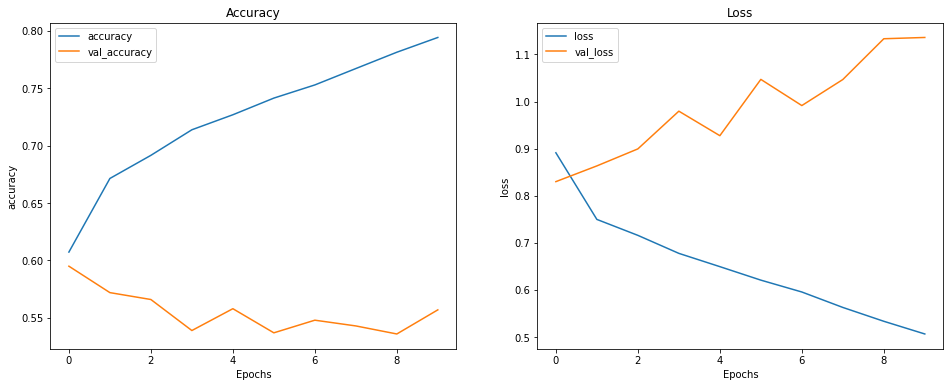

In [15]:
import matplotlib.pyplot as plt
def plot_graphs(result, metric, title):
  plt.plot(result.history[metric])
  plt.plot(result.history['val_'+metric], '')
  plt.title(title)
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(result2, 'accuracy', 'Accuracy')
plt.subplot(1, 2, 2)
plot_graphs(result2, 'loss', 'Loss')

In [16]:
loss2, acc2 = model2.evaluate(test_vector, test_sentiment_vector)
print("Loss: {}, Accuracy: {}".format(loss2, acc2))

32/32 [==============================] - 2s 72ms/step - loss: 1.0153 - accuracy: 0.6080
Loss: 1.0152567625045776, Accuracy: 0.6079999804496765


Text(33.0, 0.5, 'Actual')

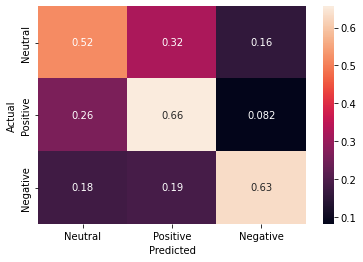

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

labels2=['Neutral','Positive','Negative']
pred2 = model2.predict(test_vector)
pred_cat2 = tf.argmax(pred2, axis=-1)
actual_cat2 = tf.argmax(test_sentiment_vector, axis=-1)
confusion_mat2 = tf.math.confusion_matrix(actual_cat2, pred_cat2)
confusion_mat2 = confusion_mat2/confusion_mat2.numpy().sum(axis=1)[:, tf.newaxis]
sns.heatmap(confusion_mat2, annot=True, xticklabels=labels2, yticklabels=labels2)
plt.xlabel("Predicted")
plt.ylabel("Actual")

--2022-01-30 11:24:34--  https://raw.githubusercontent.com/aaron6347/CPT346-Asn2/main/t1.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47548 (46K) [image/jpeg]
Saving to: ‘t1.jpg’

t1.jpg              100%[===================>]  46.43K  --.-KB/s    in 0.01s   

2022-01-30 11:24:34 (4.27 MB/s) - ‘t1.jpg’ saved [47548/47548]

--2022-01-30 11:24:34--  https://raw.githubusercontent.com/aaron6347/CPT346-Asn2/main/t2.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 45882 (45K) [image/jpeg]
Saving to: ‘t2.jpg’

t2.jpg           

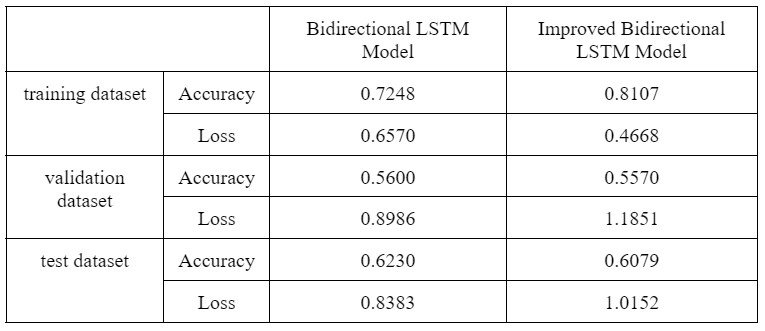

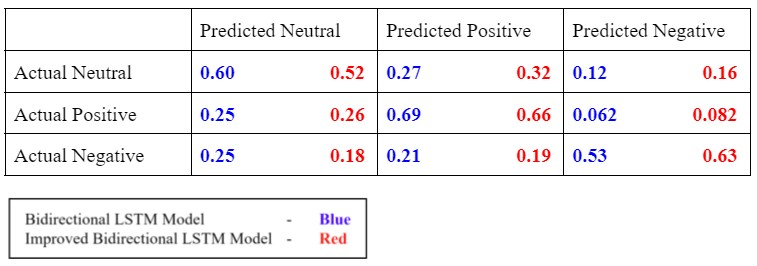

In [8]:
!wget -O 't1.jpg' 'https://raw.githubusercontent.com/aaron6347/CPT346-Asn2/main/t1.jpg'
!wget -O 't2.jpg' 'https://raw.githubusercontent.com/aaron6347/CPT346-Asn2/main/t2.jpg'
from IPython.display import Image
listOfImageNames = ['t1.jpg',
                    't2.jpg']

for imageName in listOfImageNames:
    display(Image(filename=imageName))